# Solution of Differential Algebraic Equations with Manifold Constraints on the Latent Space of an Autoencoder
## Alejandro Francisco Queiruga

## Outline

1. What problems am I trying to solve?
2. Branching logic for phases
3. Rephrasing our equations
4. The classical pendulum
5. Autoencoders
6. Unsupervised Learning
7. LatentSim

## What kinds of problems?

<img src='slides/simple_wells.png' width=500>

Single phase Darcy's law is easy:

\begin{equation}
M \partial_t p = \nabla \cdot \frac{k}{\mu} \nabla p
\end{equation}

## What kinds of problems?

<img src='slides/complex_wells.png' width=500>

- Gets combinatorically more compolicated
- Big ranges in our problems: depths, temperature fluxes, chemical
  compositions, percipates...

\begin{align}
\partial_t \rho_{H2O} & = \nabla \cdot \frac{k_1(p,T)}{\mu} \nabla p \\
\partial_t \rho_{CO2} & = \nabla \cdot \frac{k_2(p,T)}{\mu} \nabla p \\
\partial_t \rho_{CH4} & = \nabla \cdot \frac{k_3(p,T)}{\mu} \nabla p \\
\partial_t \rho u & = \nabla \cdot \frac{k_3}{\mu} \nabla T 
\end{align}

## Multiphase representation is the hard part

<img src='slides/phase_beaker.png' width=500>

- Transition between phases
- Equilibria with coexisting phases
- Compositional changes

## Equations

The equations
\begin{align}
\partial_t \rho & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho u & = \nabla \cdot \mathbf{k'}\nabla T + s
\end{align}
The typical methodology is to use the empirical relations for density and enthalpy $h$ as a function of pressure and temperature and solve the DAE for $p$ and $T$ implicitly: 
\begin{align}
\text{Solve for}\, p(t)\, \text{and}\, T(t)\, \text{such that:}\\
\partial_t \rho(p,T) & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t \rho u(p,T) & = \nabla \cdot \mathbf{k'}\nabla T + s
\end{align}
The complicatation is that the functions $\rho(p,T)$ and $u(p,T)$ are not well defined functions due to the presence of phase changes that yield sharp discontinuities in $p,T$, as shown in Figure 1 for water. The material can exist on this section of the surface as a mixture of the two phases.

## Water Phase Boundaries

![watereos](figures/phase_diagram.png)

What is a phase?

- Human object recognition distinguishes phases
- Sudden changes in material properties

## Water EOS

In [4]:
from IPython.display import IFrame
IFrame('figures/water_eos.html',width=700,height=500)

Used IAPWS empirical fits to make this data set. Colored by phase, including mixtures.

## Water EOS

<img src="figures/water_eos.png" width=500>
Used IAPWS empirical fits to make this data set. Colored by phase, including mixtures.

# Curve fits are complicated:

```python
def gibbs_liquid_h2o(T,p):
    p1_star = 1.653e7
    T1_star  = 1.386e3
    n1 = [ 0.14632971213167e00, -0.84548187169114e00,
          -3.7563603672040e+00,  3.3855169168385e+00, 
          -0.95791963387872e00,  0.15772038513228e00,
          -1.6616417199501e-02,  8.1214629983568e-04, 
           2.8319080123804e-04, -6.0706301565874e-04,
          -1.8990068218419e-02, -3.2529748770505e-02, 
          -2.1841717175414e-02, -5.2838357969930e-05,
          -4.7184321073267e-04, -3.0001780793026e-04, 
           4.7661393906987e-05,
          
          -4.4141845330846e-06,
          -7.2694996297594e-16, -3.1679644845054e-05, 
          -2.8270797985312e-06, -8.5205128120103e-10,
          -2.2425281908000e-06, -6.5171222895601e-07, 
          -1.4341729937924e-13, -4.0516996860117e-07,
          -1.2734301741641e-09, -1.7424871230634e-10, 
          -6.8762131295531e-19,  1.4478307828521e-20,
           2.6335781662795e-23, -1.1947622640071e-23, 
           1.8228094581404e-24, -9.3537087292458e-26  ]
    i1 = [  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,   
            1,  2,  2,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,    
            8,  8, 21, 23, 29, 30, 31, 32  ]
    j1 = [ -2, -1,   0,   1,   2,   3,   4,   5, -9, -7, -1,  0,  1,    
               3, -3,   0,   1,   3,  17,  -4,   0,  6, -5, -2, 10, -8,   
              -11, -6, -29, -31, -38, -39, -40, -41  ]
    p_i = p/p1_star
    t_i = T1_star/T
    return R*T*sum([ n*(7.1-p_i)**I*(t_i-1.222)**J
            for n,I,J in zip(n1,i1,j1)])
density_region1,enthalpy_region1 = density_enthalpy(gibbs_region1)
```

## Typical way: State Machines

Gridblocks have two unknowns `X1 X2` and an additional `phase` tag.
- Gas: $X = (p,T)$ and $\rho_{gas}(p,T) = $ one fit
- Liquid: $X = (p,T)$ and $\rho_{liq}(p,T) = $ another fit
- Liq-Gas: $X = (S,T)$ and $\rho_{mix}(S,T) = S \rho_{gas}(p^*(T),T)+ (1-S) \rho_{liq}(p^*(T),T)$ 

<img src='slides/phase_2.png' width=500>

- Need potentially different variables for each state, 
- Especially equilibria require a phase saturation $S$
- Need logic to handle state of the material
- Note: The phase space is not analytic in any pair choice of $T,p,\rho,h$ in the general case.
- Could do $\rho,h$ with only liquid+gas.

## Typical way: State Machines

It gets combinatorically more complex:

<img src='slides/phase_4.png' width=500>

- 8 states (4 phases with 4 equilibria surfaces)
- 10 possible state transitions
- Only one material!
- (There are more crystal phases we didn't consider.)

# State machine for phase transitions:

```C
switch phase_old:
  case gas:
    if p,T crossing boundary:
      phase_new = liquid_gas
  case liquid:
    if p,T crossing boundary:
      phase_new = liquid_gas
  case liquid_gas:
    if S_gas >= 1:
      phase_new = gas
    if S_liquid >= 1:
      phase_new = gas
```

- Forced into thinking about gridblocks with states.
- Lots of bug ridden coding!

## Solution Algorithm

State machine adds logic:
```python
X = float cell primary variables
p = integer cell state tags
for time in timesteps:
    while error < tol:
        for block in gridblocks:
            assemble switching on state tag
        X += K\R
        for block in gridblocks:
            if state transition:
                X[block] = swap_primaries(X[block],old_tag,new_tag)
                old_tag = new_tag
```
- No quadratic convergence
- Easily unstable! Need a lot of hacks, like overshoots:
\begin{equation}
p_{new} = (1+10^{-6})p_{old}
\end{equation}

## How do we solve this better?

Take a step back:
- Material as a manifold of possible intensive properties
- How do we represent this manifold?
- **It's just empirical data**
- We have observations and expect to stay on these observations.
- We just need _**any**_ representation of this constraint.

## A Constrained Differential Algebraic Equation


Solve for $\rho(t), \, h(t), \, p(t),\, \text{and}\, T(t)$ satisfying:
\begin{align}
\partial_t \rho & = \nabla \cdot \mathbf{k}\nabla p + r\\
\partial_t (\rho h-p) & = \nabla \cdot \mathbf{k'}\nabla T + s\\
\end{align}
such that they lie on the material EOS,
\begin{equation}
EOS(\rho,h,p,T) = 0
\end{equation}
We just made the problem harder.

## The Archetypical Constraint Problem: The Pendulum

Solve for $x(t),y(t)$ stationary on
\begin{equation}
\mathcal{L}(x,y) = \frac{1}{2}m\left(\dot{x}^2 + \dot{y}^2\right) - m g y
\end{equation}
subject to
\begin{equation}
x^2 + y^2 = R
\end{equation}
The Lagrangian mechanics formulation lets us introduce a parameterization:
\begin{equation}
x = R \cos \theta, \quad y = R \sin \theta
\end{equation}
to plug into the Lagrangian:
\begin{equation}
\mathcal{L}(\theta) = \frac{R^2}{2} \dot{\theta}^2 + g R \sin \theta
\end{equation}
The equations of motion in terms of $\theta$ are then:
\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\frac{\partial L}{\partial \dot{\theta}} = \frac{\partial L}{\partial \theta}
\end{equation}

## The Pendulum

The choice of $\theta$ is arbitrary. There are infinimately choices. 

Suppose we only have data:

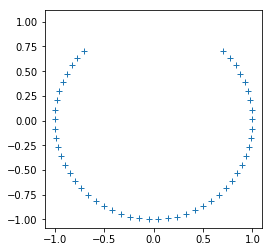

In [9]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
theta = np.linspace(-np.pi*1.25,0.25*np.pi,50, dtype=np.float32)
data = np.vstack([np.cos(theta), np.sin(theta)]).T
plt.plot(data[:,0],data[:,1],'+')
plt.axis('square');

We're looking for a mapping from the set of points onto one variable.

## Autoencoders

![autoencoder](slides/autoencoders.png)

$\theta$ is one instance of an **autoencoder**. We can look for one without the geometric intuition.

## Autoencoders
Solve the minimization problem on data set $x$ for parameters $a$
\begin{equation}
\min_a \sum_x \left( x - D(E(x;a);a) \right)^2
\end{equation}
where $q = E(x)$
with `len(q)<len(x)`.

- $q$ represents a point on the *Latent Space*
- Pick the dimension of $q$ based on prior intuition of the manifold (or tune it)
- Pendulum is a 1D manifold, so look for 1D $q$
- It's infinitely differentiable so let's use polynomials:

```python
    def encode(self, x, name=None):
        N_coeff = atu.Npolyexpand( self.size_x, self.Np_enc )
        We1 = self._var("enc_W", (N_coeff, self.size_q) )
        be1 = self._var("enc_b", (self.size_q,) )
        q = tf.matmul( atu.polyexpand(x, self.Np_enc), We1 ) + be1
        return tf.identity(q,name=name)
    def decode(self, q, name=None):
        N_coeff = atu.Npolyexpand( self.size_q, self.Np_dec )
        We1 = self._var("dec_W", (N_coeff, self.size_x) )
        be1 = self._var("dec_b", (self.size_x,) )
        x = tf.matmul( atu.polyexpand(q, self.Np_dec), We1 ) + be1
        return tf.identity(x,name=name)
    def make_goal(self, data):
        pred = self.decode(self.encode(data))
        # p = tf.reduce_sum(tf.pow( data - pred, 2) ) 
        p = tf.losses.mean_squared_error(data, pred)
        return p
```

### Caveats: Topology

We can't encode a full circle. The inner space is of an arbitrary autoencoder is a plane. We would need multiple charts to span the circle (more dimensions to $q$ + chart selection), or pick an encoder that maps onto the right topology. 

![bad pendulum](figures/bad_pendulum.png)

Fortunately EOSes are disks so we don't need to solve this problem.

## Solving the Lagrangian: Just do it.

Treat the autoencoder the same as $x(\theta)$, plugging in $L(x(q),v(q,\dot{q}))$
\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\frac{\partial L}{\partial \dot{q}} = \frac{\partial L}{\partial q}.
\end{equation}
where we get the velocity with:
\begin{equation}
v = \frac{\partial x}{\partial q} \dot{q}
\end{equation}

Implement it in the TensorFlow syntax:
```python
def L(i_q,i_qdot):
    x = au.decode(i_q)
    dxdq = atu.vector_gradient(x,i_q)
    v = tf.einsum("ikj,ij->ik",dxdq,i_qdot)
    L = 0.5*tf.einsum("ij,ij->i",v,v) - g*x[:,1]
    return x,v, tf.expand_dims(L,-1)
```

## Solving the Lagrangian: Just do it.
Then we just build the expressions we need:
```python
o_x,o_v,Li = L(i_qi,i_vi)
dLi_dv = atu.vector_gradient(Li,i_vi)
dLi_dq = atu.vector_gradient(Li,i_qi)
```
descritize in time with a one-step implicit Runge-Kutta
```python
lhs = dLi_dv - Dt * aii * dLi_dq
rhs = dL0_dv + Dt * (1.0-aii) * dL0_dq
```
and take the tangents we need:
```python
KV = atu.vector_gradient(lhs,i_vi)
KQ = atu.vector_gradient(lhs,i_qi)
Ktot = Dt*KQ + KV
```

Then we do a Newton's method loop:
```python
# Encode an initial condition
theta_init = - 0.5*np.pi/2.0
x_init = np.array([[np.cos(theta_init),np.sin(theta_init)]])
q_0[:] = au.o_q.eval(feed_dict={au.i_x:x_init})
v_0[:] = 0.0
for it in range(1000):
    # Macro for tensorflow call
    ev = lambda x : sess.run(x,feed_dict
        ={i_qi:q_i,i_q0:q_0, i_vi:v_i, i_v0:v_0})
    rhs_0 = ev(rhs)
    # Newton's method loop
    for k in range(10):
        # Assemble
        K_k,lhs_k= ev(Ktot), ev(lhs)
        R = rhs_0 - lhs_k
        # Solve for update to qdot
        Dv = np.linalg.solve(K_k[0,:,:], R[0,:])
        v_i[:] += Dv
        # Use second-order RK formula to update q
        q_i[:] = q_0 + ev(Dt)*((1.0-aii)*v_0 + aii*v_i)
        n = np.linalg.norm(Dv)
        if n<2.0e-7: break
    v_0[:] = v_i[:]
    q_0[:] = q_i[:]
    # Saving data requires calling the decoder
    series_x.append(ev(o_x)[0,:])
    series_v.append(ev(o_v)[0,:])
```

Copy-and-paste of the implementation!

## Solutions of the Pendulum

<img src="figures/pendulum_q.png" width=800>

# Back to Multiphase EOS

Solve for $u(t)$ and $v(t)$ such that:
\begin{align}
\partial_t \rho(u,v) & = \nabla \cdot \mathbf{k} \nabla p(u,v) + r \\
\partial_t \rho h(u,v)-p & = \nabla \cdot \mathbf{k'}\nabla T(u,v) + s
\end{align}
where $\rho(u,v)$ etc. are the back of an autoencoder:
\begin{equation}
\left\{ \begin{array}{c}
T\\ p\\ \rho\\ h
\end{array}\right\} \rightarrow  E \rightarrow 
\left\{ \begin{array}{c} u\\v \end{array} \right\}\rightarrow D \rightarrow 
\left\{ \begin{array}{c}
T\\ p\\ \rho\\ h
\end{array}\right\}
\end{equation}
Using the autoencoder to automatically remove the local constraint.

**Only training the material representation, not the balance laws.**

## Methodology

1. Make a database of $T,p,\rho,h,X_1,...$
  - Piece together empirical fits for each phase
  - Put equilibria into database
1. Normalize (and $\log(p)$) the database, shuffle it
  - Zero-mean and unit-range numbers
  - $\log(p)$ distributes the low-$p$ phases evenly w.r.t. high-$p$ phases
1. Train the autoencoder
  - Batch test architectures
  - Don't use phase labels
1. Insert model into balance DAE
  - Load it from the checkpoint
1. Verify and grade architectures on tests
1. Pick best one to package into production code

## Model Architectures

- Very low dimensions compared to popular ML
- Empirical fits doing polynomials and exponents with dozens of parameters before
- We want differentiability
- Decoding is more complex than encoding
- How can we interpret the results?

## Model Architectures

![normal networks](slides/networks.png)

## Model Architectures

![normal networks](slides/classifier_network.png)

Allows for unsupervised learning of phases based on what makes a good fit.

## Feature Identification

<video controls preload="auto" width="500">
<source src="slides/evo.mp4" type="video/mp4">
Your browser does not support the video tag.
</video>

## Compare to the original labels:

![watereos](figures/water_eos.png)

## Sometimes they fail

![failure](slides/classifier_bad.png)

Same architecture optimized with a different seed.

In [9]:
IFrame("http://localhost:8097",1200,650)

## Implementation notes

Software:
- Tensorflow for the networks and the DAE
- Plotly for plots
- Visdom for looking at all the plots
- Paraview for that video
- Some open source stuff at [github/afqueiruga/afqstensorutils](https://github.com/afqueiruga/afqstensorutils) (More be released soon)

Notes:
- Do the triangulation (qhull) in $q$-space to make the surface

## Testing the Method

Three different extents:
1. Linear Equation of State  
  - Reduces to Poisson problem (slide 1)
  - $ p = 10^5+[-10^3, 10^3],\quad T = [ 19, 21 ] $
2. Water Liquid-Gas Regime  
  - One phase boundary  
  - $ p = [], \quad T = [] $
3. Water Solid-Liquid-Gas-Supercritical Regimes  
  - No linear mapping to latent space  
  - Entire span

Multiple test problems:

## Autoprogramming

How can express our goals, and check we achieved them?

We're looking for a component of our computer program:
```python
def main(initial conditions):
    q = some unknowns on a mesh
    q[] = ENCODE(initial conditions)
    for t in times:
        while error > tolerance:
            for block in mesh:
                R,K += Assemble(system_of_eqs(q))
            q += K\R
        output(DECODE(q))
def system_of_eqs(q):
    T,p,rho,h = DECODE(q)
    mass = [ rho,
             rho*h - p ]
    rate = [ k_p*(p_inf-p)+mass_source,
             k_T*(T_inf-T)+heat_source ]
    R = generate_runge_kutta(mass, rate)
    return R, diff(R, q)
@train(ENCODE(x), DECODE(q))
def program_goal(data):
    return msq(data - DECODE(ENCODE(data)))
@test
def test_case_1():
    assert( main( test_1 ) == known results )
```
We don't know what `DECODE` is, and we don't care about the meaning of `q`. 

## Conclusions

- We did stuff
- Can do unsupervised phase classification
- **Only training the material, not the balance laws.**
- Extend to more complicated materials: methane hydrates
- Put into a flow simulation
- Optimize the networks

Open applications:
- Use the encoder to eliminate global constraints?
- Encode functional forms ($c(x)=0$) instead of datasets ($\{x_i\,\,\text{s.t.}\,\,c(x_i)=0\}$)

# Thank you